In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sklearnex import patch_sklearn
patch_sklearn(global_patch=True)

Scikit-learn was successfully globally patched by Intel(R) Extension for Scikit-learn


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from src.data.toy_data import *
from src.model.boosted_support_subset import *
from src.visualization.plots import *
from src.utils import *

# Overlapping bivariate normals

In [8]:
# Parameters
seed1 = 1
seed2 = 2
n0 = 1000
n1 = 1000

# Dataset 1
mu0 = [0, 0]
sigma0 = [[1, 0], [0, 1]]
mu1 = [3, 3]
sigma1 = [[1, 0], [0, 1]]

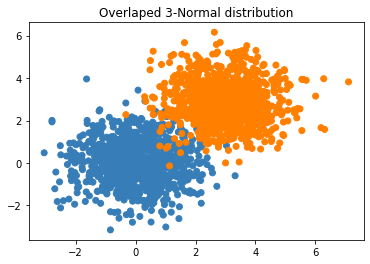

In [9]:
X, y = normal_generator2(mu0, sigma0, n0, mu1, sigma1, n1, seed1, seed2)
plot_toy_set(X, y, 'Overlaped 3-Normal distribution')

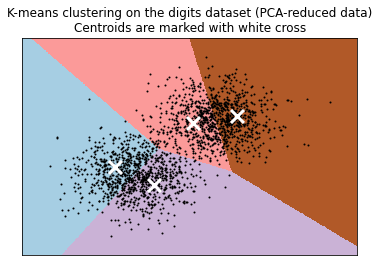

In [10]:
# Step size of the mesh. Decrease to increase the quality of the VQ.
kmeans_fitted = KMeans(n_clusters=4, random_state=1234).fit(X)
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans_fitted.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(X[:, 0], X[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans_fitted.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

## Random forest

In [11]:
rf = RandomForestClassifier(n_estimators=100, max_features='auto', criterion='gini',random_state=1324)

In [12]:
preds = StratifiedKFoldTestPredictions(X, y, rf)
confusion_matrix(preds, y)

real,0,1,total
pred,,,
0,0.49,0.01,0.5
1,0.01,0.49,0.5
total,0.50,0.50,1.0


In [13]:
rf.fit(X, y)

RandomForestClassifier(random_state=1324)

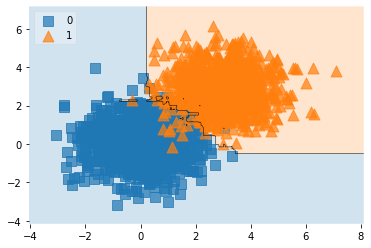

In [14]:
fig1 = plt.gcf()
custom_decision_region_plot(X, y, rf, title='')

## SVM

In [15]:
svm = SVC(C=1, gamma = 1)

In [16]:
preds = StratifiedKFoldTestPredictions(X, y, svm)
confusion_matrix(svm.predict(X), y)

real,0,1,total
pred,,,
0,0.49,0.01,0.5
1,0.01,0.49,0.5
total,0.50,0.50,1.0


In [17]:
svm.fit(X, y)

SVC(C=1, gamma=1)

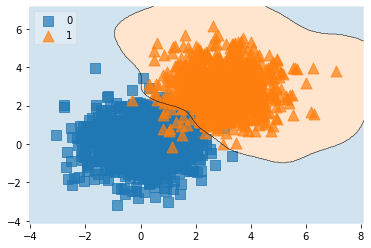

In [18]:
fig1 = plt.gcf()
custom_decision_region_plot(X, y, svm, title='')

## BSS

In [40]:
clf = BoostedSupportSubset(params={'C': 1, 'gamma': 1, 'kernel': 'rbf'}, k=4, prop_sample=0.5, n_learners=None, max_features='auto', support_subset = True)

In [41]:
preds = StratifiedKFoldTestPredictions(X, y, clf)
confusion_matrix(preds, y)

real,0,1,total
pred,,,
0,0.49,0.01,0.5
1,0.01,0.49,0.5
total,0.50,0.50,1.0


In [42]:
clf.fit(X, y, n_jobs=-1)

In [43]:
len(clf.learners)

36

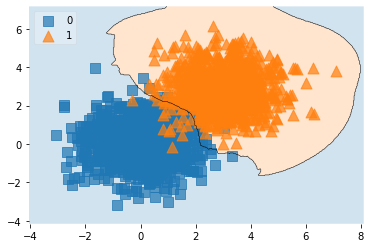

In [44]:
fig1 = plt.gcf()
custom_decision_region_plot(X, y, clf, title='')

### Limited learners detail

/home/vacek/anaconda3/envs/fast_bss/lib/python3.9/site-packages/mlxtend/plotting/decision_regions.py:243: UserWarning: No contour levels were found within the data range.
  ax.contour(xx, yy, Z, cset.levels,
/home/vacek/anaconda3/envs/fast_bss/lib/python3.9/site-packages/mlxtend/plotting/decision_regions.py:243: UserWarning: No contour levels were found within the data range.
  ax.contour(xx, yy, Z, cset.levels,
/home/vacek/anaconda3/envs/fast_bss/lib/python3.9/site-packages/mlxtend/plotting/decision_regions.py:243: UserWarning: No contour levels were found within the data range.
  ax.contour(xx, yy, Z, cset.levels,
/home/vacek/anaconda3/envs/fast_bss/lib/python3.9/site-packages/mlxtend/plotting/decision_regions.py:243: UserWarning: No contour levels were found within the data range.
  ax.contour(xx, yy, Z, cset.levels,


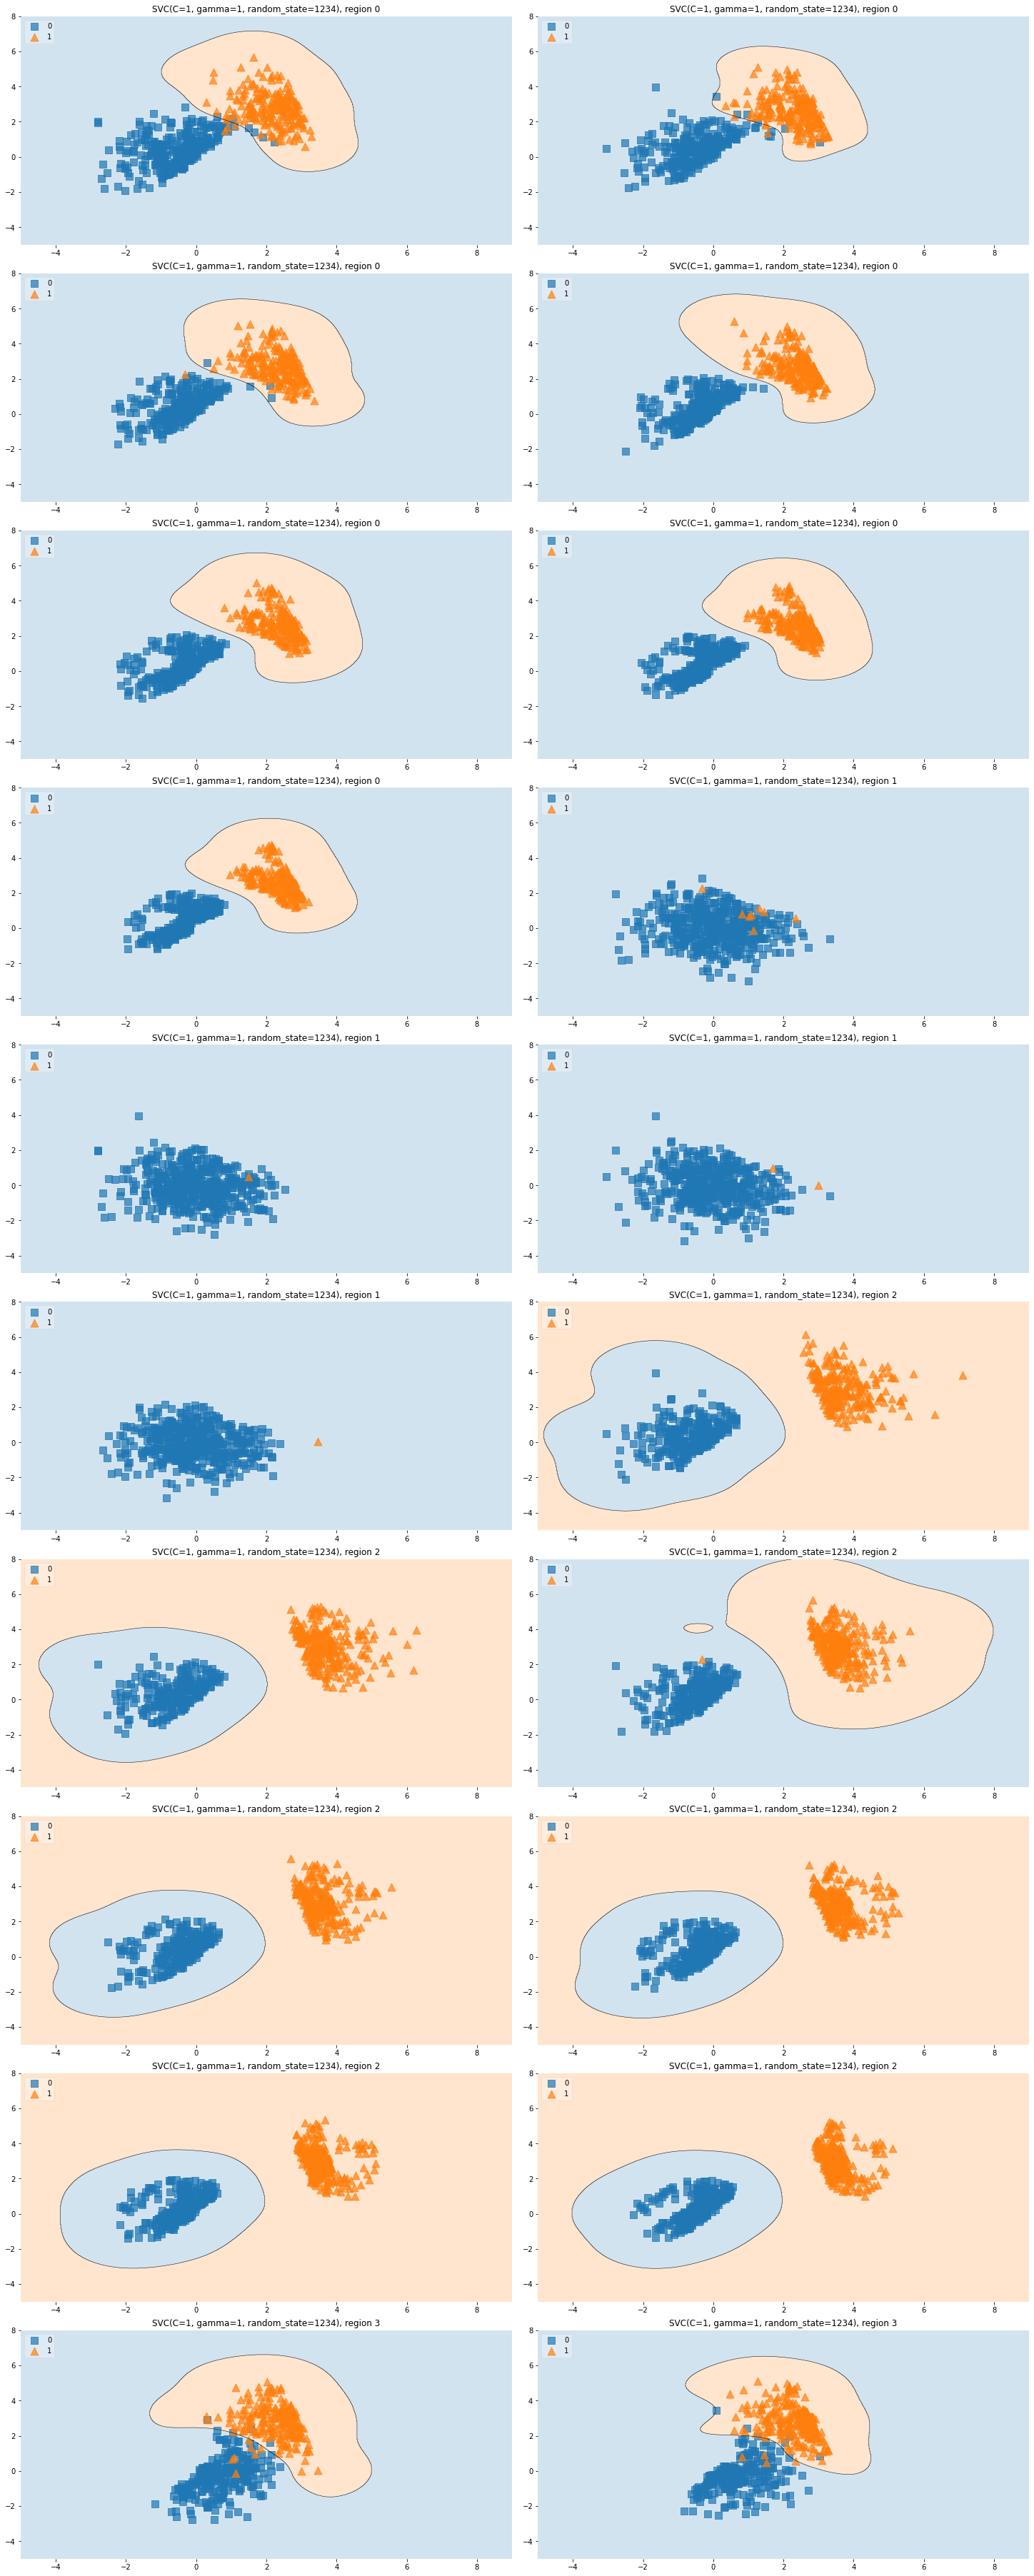

In [45]:
learners = [learner for learner in clf.learners if learner['learner'] is not None]
learners_decision_regions_plot(X, y, learners[:20], zoom=0.1)